In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

# Analyze data

### Demographic information

In [2]:
df_demo = pd.read_csv('../data/ICBHI_Challenge_demographic_information.txt', sep='\t', header=None)
df_demo = df_demo.rename(columns={0: 'ID', 1: 'age', 2: 'sex', 3: 'BMI', 4: 'weight', 5: 'height'})
df_diagnosis = pd.read_csv('../data/ICBHI_Challenge_diagnosis.txt', sep='\t', header=None)
df_diagnosis = df_diagnosis.rename(columns={0: 'ID', 1: 'diagnosis'})

df = pd.merge(df_demo, df_diagnosis, on='ID')
df.head()

,ID,age,sex,BMI,weight,height,diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


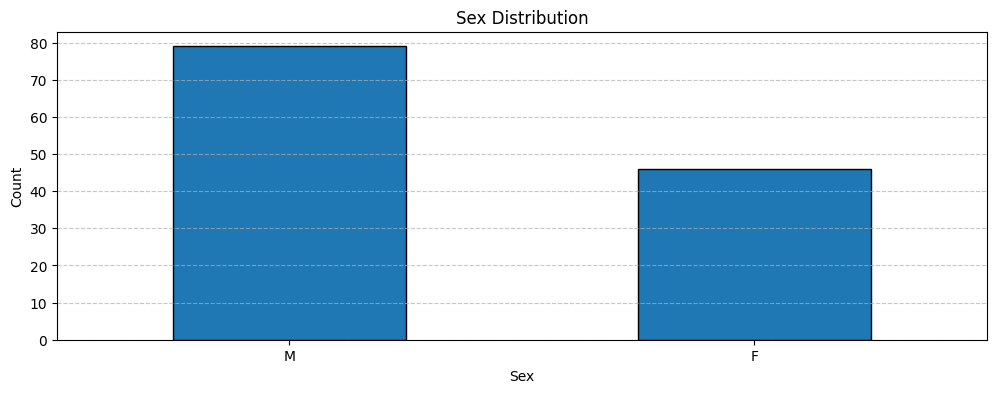

In [3]:
plt.figure(figsize=(12, 4))
df['sex'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

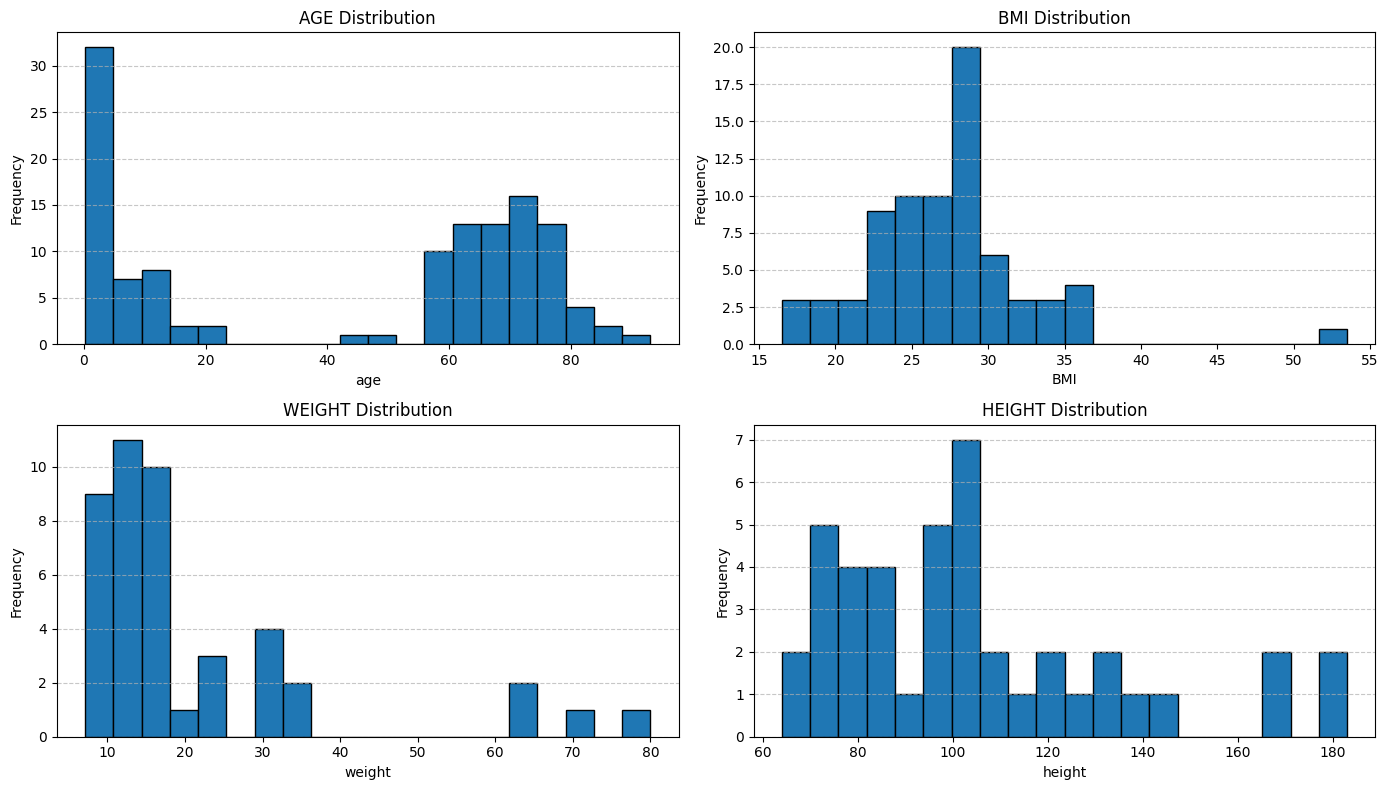

In [4]:
fig, axs = plt.subplots(2,2, figsize=(14, 8))

columns = ['age', 'BMI', 'weight', 'height']
plot_num = 0

for i in range(2):
    for j in range(2):       
        
        axs[i, j].hist(df[columns[plot_num]], bins=20, edgecolor='black')
        axs[i, j].set_title(f'{columns[plot_num].upper()} Distribution')
        axs[i, j].set_xlabel(columns[plot_num])
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].grid(axis='y', linestyle='--', alpha=0.7)
        
        plot_num += 1
plt.tight_layout()
plt.show()

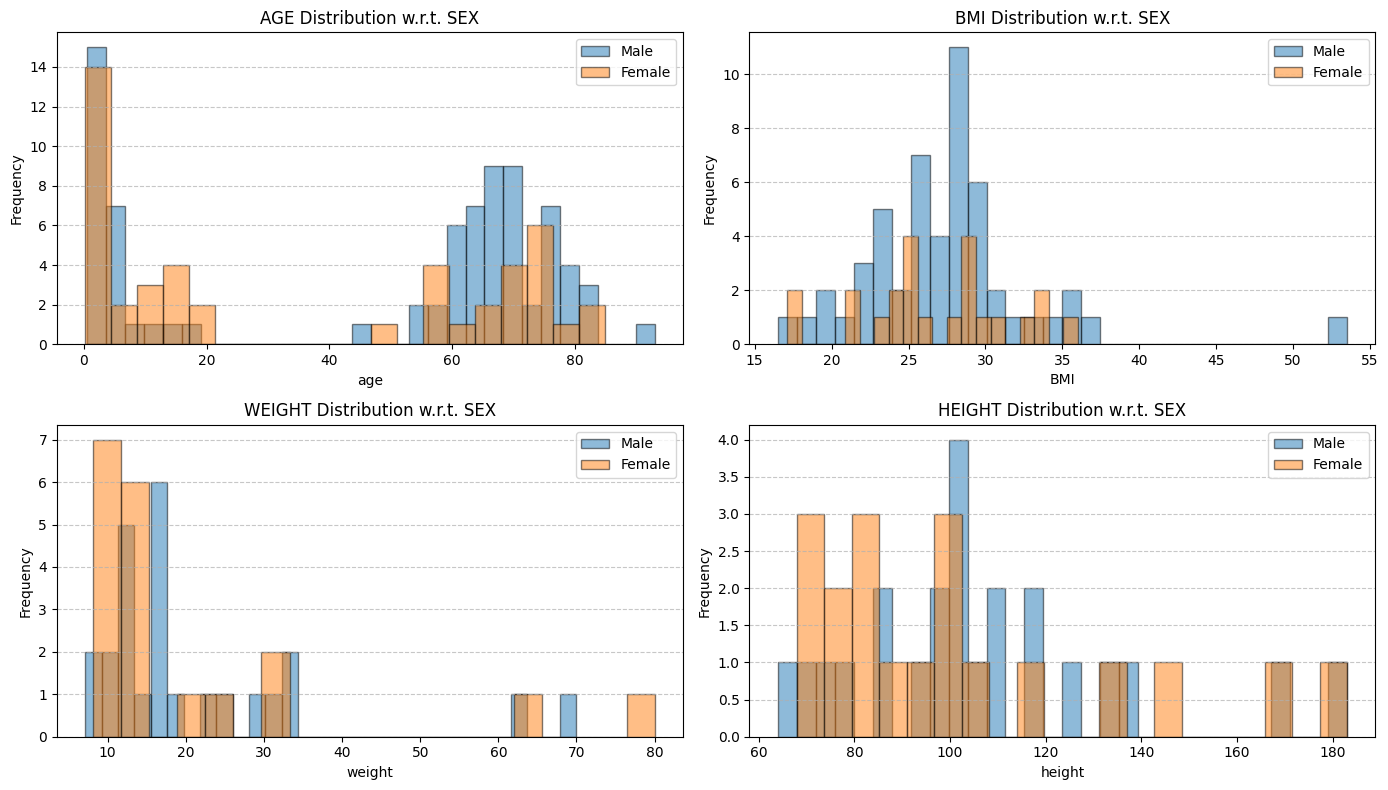

In [5]:
fig, axs = plt.subplots(2,2, figsize=(14, 8))

columns = ['age', 'BMI', 'weight', 'height']
plot_num = 0

for i in range(2):
    for j in range(2):       
        
        axs[i, j].hist(df[df['sex'] == 'M'][columns[plot_num]], bins=30, alpha=0.5, edgecolor='black', label='Male')
        axs[i, j].hist(df[df['sex'] == 'F'][columns[plot_num]], bins=20, alpha=0.5, edgecolor='black', label='Female')
        axs[i, j].set_title(f'{columns[plot_num].upper()} Distribution w.r.t. SEX')
        axs[i, j].set_xlabel(columns[plot_num])
        axs[i, j].set_ylabel('Frequency')
        axs[i, j].grid(axis='y', linestyle='--', alpha=0.7)
        axs[i, j].legend()
        
        plot_num += 1
plt.tight_layout()
plt.show()

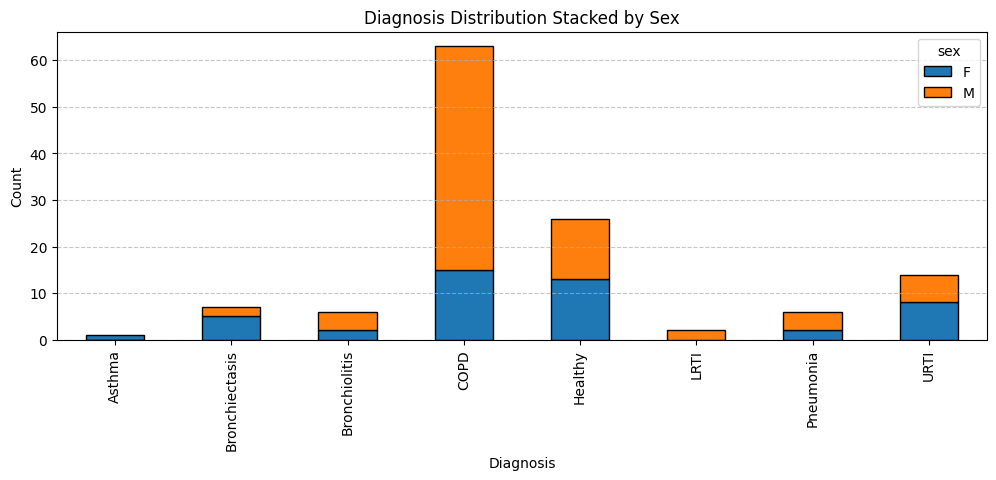

In [6]:
plt.figure(figsize=(12, 4))

df.groupby(['diagnosis', 'sex']).size().unstack().plot(kind='bar', stacked=True, ax=plt.gca(), edgecolor='black')

plt.title('Diagnosis Distribution Stacked by Sex')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Detailed events analysis

In [7]:
df_events = pd.DataFrame([])

for file_name in os.listdir('../data/events/'):
    file_path = os.path.join('../data/events/', file_name)

    if os.path.getsize(file_path) == 0:
        continue
    
    df = pd.read_csv(file_path, sep='\t', header=None, names=['start_time', 'end_time', 'event'])
    df['duration'] = df['end_time'] - df['start_time']
    df['event'] = df['event'].str.strip()
    
    df_events = pd.concat([df_events, df], axis=0)

df_events.head()

,start_time,end_time,event,duration
0,0.350,0.371,crackle,0.021
1,0.789,0.822,crackle,0.033
2,2.085,2.113,crackle,0.028
3,2.121,2.155,crackle,0.034
4,2.463,2.506,crackle,0.043


Total Events: 10775
Total crackles: 8877 (82.39%)
Total wheeze: 1898 (17.61%)


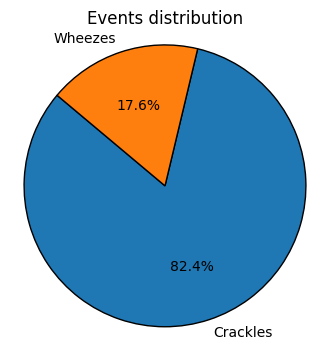

In [8]:
df_crackle = df_events[df_events['event'] == 'crackle']
df_wheeze = df_events[df_events['event'] == 'wheeze']

print(f"Total Events: {len(df_events)}")
print(f"Total crackles: {len(df_crackle)} ({len(df_crackle)/len(df_events)*100:.2f}%)")
print(f"Total wheeze: {len(df_wheeze)} ({len(df_wheeze)/len(df_events)*100:.2f}%)")

plt.figure(figsize=(4, 4))
plt.pie([len(df_crackle), len(df_wheeze)], labels=['Crackles','Wheezes'],
        autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title(f"Events distribution")
plt.axis('equal') 

plt.show()

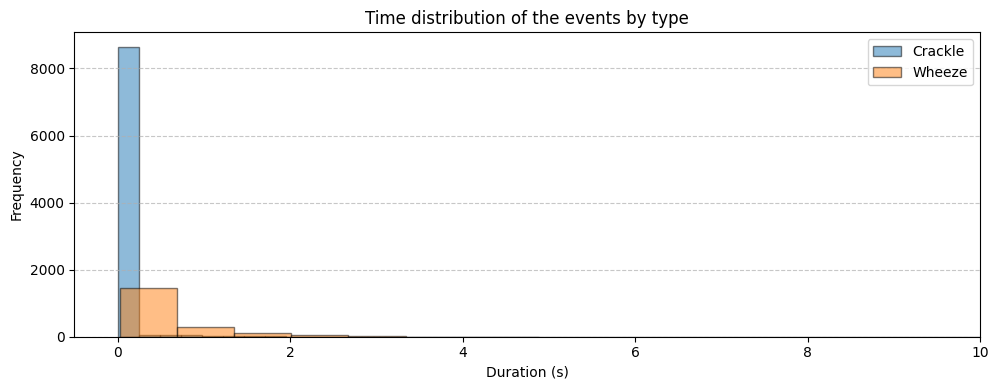

In [9]:
plt.figure(figsize=(10, 4))

plt.hist(df_crackle['duration'], bins=20, alpha=0.5, label='Crackle', edgecolor='black')
plt.hist(df_wheeze['duration'], bins=30, alpha=0.5, label='Wheeze', edgecolor='black')

plt.xlabel('Duration (s)')
plt.ylabel('Frequency')
plt.title('Time distribution of the events by type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.xlim([-0.5, 10])
plt.show()

## Experts annotations

In [10]:
data_list = []

for file_name in os.listdir('../data/ICBHI_final_database/'):
    if file_name.endswith('.txt'):
        file_path = os.path.join('../data/ICBHI_final_database/', file_name)
        
        df = pd.read_csv(file_path, sep="\t", header=None, names=["start_time", "end_time", "crackle", "wheeze"])

        data_list.append(df)

df_experts = pd.concat(data_list, ignore_index=True)
df_experts['duration'] = df_experts['end_time'] - df_experts['start_time']

print(f"Total Cycles: {len(df_experts)}")
print(f"Total Crackles: {df_experts['crackle'].sum()} ({df_experts['crackle'].sum()/len(df_experts)*100:.2f}%)")
print(f"Total Wheezes: {df_experts['wheeze'].sum()} ({df_experts['wheeze'].sum()/len(df_experts)*100:.2f}%)")

print(f"\nAverage cycle duration: {df_experts['duration'].mean():.2f} seconds")
print(f"Average cycle duration - Crackles: {df_experts[df_experts['crackle'] > 0]['duration'].mean():.2f} seconds")
print(f"Average cycle duration - Wheezes: {df_experts[df_experts['wheeze'] > 0]['duration'].mean():.2f} seconds\n")

df_experts.head()

Total Cycles: 6995
Total Crackles: 2370.0 (33.88%)
Total Wheezes: 1392.0 (19.90%)

Average cycle duration: 2.70 seconds
Average cycle duration - Crackles: 2.84 seconds
Average cycle duration - Wheezes: 2.83 seconds



,start_time,end_time,crackle,wheeze,duration
0,0.0,1.0665,0.0,0.0,1.0665
1,1.0665,2.5256,0.0,0.0,1.4591
2,2.5256,4.7475,0.0,0.0,2.2219
3,4.7475,7.2102,0.0,0.0,2.4627
4,7.2102,10.0620,0.0,0.0,2.8518


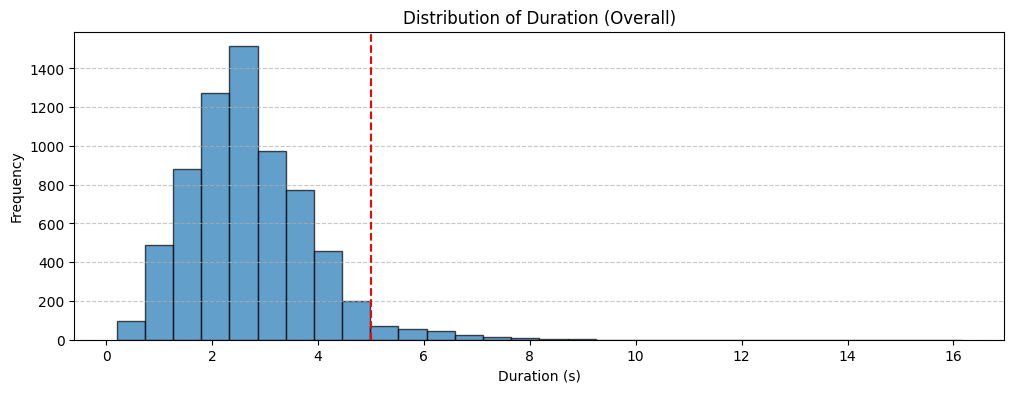

In [13]:
plt.figure(figsize=(12, 4))
plt.hist(df_experts['duration'], bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=5, color='red', linestyle='--')
plt.title("Distribution of Duration (Overall)")
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

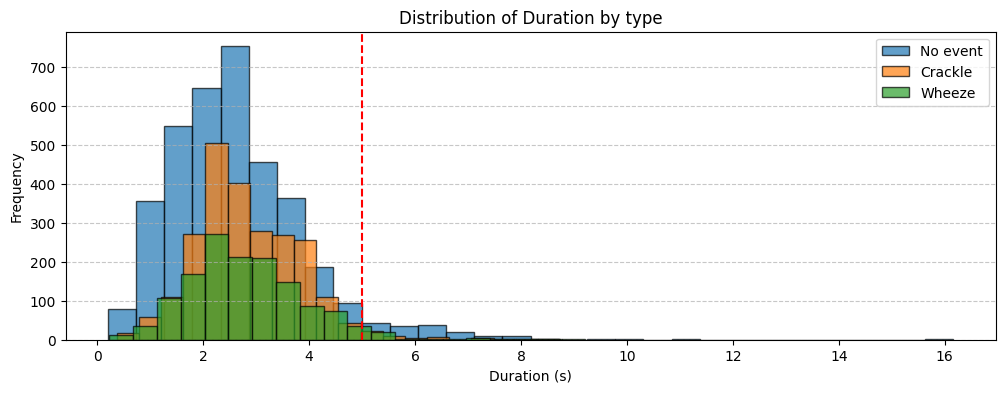

In [15]:
plt.figure(figsize=(12, 4))

plt.hist(df_experts[(df_experts['crackle'] == 0) & (df_experts['wheeze'] == 0)]['duration'], bins=30, alpha=0.7, label="No event", edgecolor='black')
plt.hist(df_experts[df_experts['crackle'] == 1]['duration'], bins=20, alpha=0.7, label="Crackle", edgecolor='black')
plt.hist(df_experts[df_experts['wheeze'] == 1]['duration'], bins=20, alpha=0.7, label="Wheeze", edgecolor='black')

plt.axvline(x=5, color='red', linestyle='--')
plt.title("Distribution of Duration by type")
plt.xlabel("Duration (s)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
shorter_than_5 = (df_experts['duration'] < 5).sum()
total_cycles = len(df_experts)
percentage_shorter_than_5 = (shorter_than_5 / total_cycles) * 100

shorter_than_5s_overall = (df_experts['duration'] < 5).sum()
shorter_than_5s_crackle = (df_experts[df_experts['crackle'] > 0]['duration'] < 5).sum()
shorter_than_5s_wheeze = (df_experts[df_experts['wheeze'] > 0]['duration'] < 5).sum()

print(f"Percentage of cycles shorter than 5 seconds (Overall): {(shorter_than_5s_overall / len(df_experts)) * 100:.2f}%")
print(f"Percentage of crackle cycles shorter than 5 seconds: {(shorter_than_5s_crackle / len(df_experts[df_experts['crackle'] > 0]))*100:.2f}%")
print(f"Percentage of wheeze cycles shorter than 5 seconds: {(shorter_than_5s_wheeze / len(df_experts[df_experts['wheeze'] > 0]))*100:.2f}%")

Percentage of cycles shorter than 5 seconds (Overall): 95.27%
Percentage of crackle cycles shorter than 5 seconds: 97.81%
Percentage of wheeze cycles shorter than 5 seconds: 96.34%
